In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest

# Metrics
from sklearn.metrics import precision_score, recall_score, make_scorer

# Kaggle config.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
file_path = '/kaggle/input/creditcardfraud/creditcard.csv'
df = pd.read_csv('creditcard.csv')[:80000]

df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
X = df.drop(columns=['Time', 'Amount', 'Class']).values
y = df['Class'].values

X

array([[-1.35980713, -0.07278117,  2.53634674, ..., -0.18911484,
         0.13355838, -0.02105305],
       [ 1.19185711,  0.26615071,  0.16648011, ...,  0.12589453,
        -0.0089831 ,  0.01472417],
       [-1.35835406, -1.34016307,  1.77320934, ..., -0.13909657,
        -0.05535279, -0.05975184],
       ...,
       [-2.28727012,  1.12156794,  1.16358497, ..., -0.2520452 ,
        -0.40904438, -0.25311435],
       [-1.3509413 ,  0.23341085,  0.95082419, ..., -0.27339173,
         0.35042154,  0.14085102],
       [-2.00700424,  0.73613717,  0.05184662, ..., -0.96230381,
        -0.95055099, -0.59174836]])

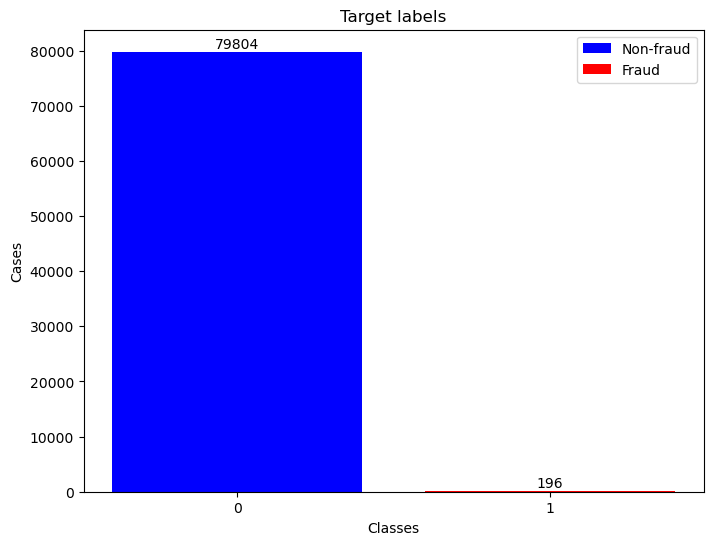

In [5]:
classes, classes_count = np.unique(df['Class'].values, return_counts=True)

plt.figure(figsize=(8, 6))
bars = plt.bar(classes, classes_count, color=['blue', 'red'])

for bar, count in zip(bars, classes_count):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 20, count,
             ha='center', va='bottom', color='black')

plt.title("Target labels")
plt.xticks(classes)

plt.xlabel("Classes")
plt.ylabel("Cases")
plt.legend(bars, ["Non-fraud", "Fraud"])

plt.show()

In [6]:
model = LogisticRegression(class_weight={0: 1, 1: 2}, max_iter=1000)

pred1 = model.fit(X, y).predict(X).sum()

print(f"Predicted number of Fraud cases : {pred1}")

Predicted number of Fraud cases : 171


In [7]:
grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in range(1, 4)]},
    cv=4,
    n_jobs=-1)

grid

GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}]})

In [8]:
grid.fit(X, y)

GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}]})

In [9]:
cv_results = pd.DataFrame(grid.cv_results_)

cv_results.sort_values(by='mean_test_score', ascending=False).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.861946,0.185537,0.004239,0.000432,"{0: 1, 1: 1}","{'class_weight': {0: 1, 1: 1}}",0.99405,0.99835,0.99945,0.9978,0.997413,0.00203,1


In [10]:
p_score = precision_score(y, grid.predict(X))
r_score = recall_score(y, grid.predict(X))

print(f"Precision Score : {p_score}\nRecall Score    : {r_score}")

Precision Score : 0.7682119205298014
Recall Score    : 0.5918367346938775


In [11]:
grid_pr = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={"precision": make_scorer(precision_score), "recall_score": make_scorer(recall_score)},
    refit='precision',
    return_train_score=True,
    cv=10,
    n_jobs=-1)

grid_pr

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 14.758620689655173},
                                          {0: 1, 1: 15.413793103448276},
                                          {0: 1, 1: 16.06896551724138},
                                          {0: 1, 1: 16.724137931034484},
                                          {0: 1, 1: 17.379310344827587},
                                          {0: 1, 1: 18.03448275862069},
                                          {0: 1, 1: 18.689655172413794},
                                          {0: 1, 1: 19.344827586206897},
                                          {0: 1, 1: 20.0}]},
             refit='precision', return_train_score=True,
             scoring={'precision': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [14]:
grid_pr.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 14.758620689655173},
                                          {0: 1, 1: 15.413793103448276},
                                          {0: 1, 1: 16.06896551724138},
                                          {0: 1, 1: 16.724137931034484},
                                          {0: 1, 1: 17.379310344827587},
                                          {0: 1, 1: 18.03448275862069},
                                          {0: 1, 1: 18.689655172413794},
                                          {0: 1, 1: 19.344827586206897},
                                          {0: 1, 1: 20.0}]},
             refit='precision', return_train_score=True,
             scoring={'precision': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [15]:
cv_results_pr = pd.DataFrame(grid_pr.cv_results_)

cv_results_pr.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,split2_train_recall_score,split3_train_recall_score,split4_train_recall_score,split5_train_recall_score,split6_train_recall_score,split7_train_recall_score,split8_train_recall_score,split9_train_recall_score,mean_train_recall_score,std_train_recall_score
0,1.154312,0.124404,0.014660,0.005427,"{0: 1, 1: 1.0}","{'class_weight': {0: 1, 1: 1.0}}",1.0,0.463415,0.583333,1.0,...,0.627119,0.548023,0.573864,0.573864,0.562500,0.613636,0.636364,0.607955,0.612185,0.054733
1,1.107537,0.154794,0.012268,0.001097,"{0: 1, 1: 1.6551724137931034}","{'class_weight': {0: 1, 1: 1.6551724137931034}}",1.0,0.463415,0.583333,1.0,...,0.683616,0.627119,0.670455,0.647727,0.630682,0.687500,0.698864,0.687500,0.680239,0.050286
2,1.229810,0.208120,0.014373,0.004049,"{0: 1, 1: 2.310344827586207}","{'class_weight': {0: 1, 1: 2.310344827586207}}",1.0,0.463415,0.583333,1.0,...,0.740113,0.683616,0.710227,0.698864,0.687500,0.715909,0.744318,0.727273,0.724454,0.043881
3,1.225696,0.106148,0.013963,0.005163,"{0: 1, 1: 2.9655172413793105}","{'class_weight': {0: 1, 1: 2.9655172413793105}}",1.0,0.452381,0.583333,1.0,...,0.785311,0.706215,0.744318,0.732955,0.715909,0.755682,0.772727,0.738636,0.749978,0.039589
4,0.907572,0.134121,0.011969,0.001092,"{0: 1, 1: 3.6206896551724137}","{'class_weight': {0: 1, 1: 3.6206896551724137}}",1.0,0.452381,0.583333,1.0,...,0.824859,0.740113,0.755682,0.744318,0.727273,0.778409,0.784091,0.761364,0.771498,0.037959


In [16]:
cv_results_pr.sort_values(by='mean_test_precision', ascending=False).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,split2_train_recall_score,split3_train_recall_score,split4_train_recall_score,split5_train_recall_score,split6_train_recall_score,split7_train_recall_score,split8_train_recall_score,split9_train_recall_score,mean_train_recall_score,std_train_recall_score
2,1.22981,0.20812,0.014373,0.004049,"{0: 1, 1: 2.310344827586207}","{'class_weight': {0: 1, 1: 2.310344827586207}}",1.0,0.463415,0.583333,1.0,...,0.740113,0.683616,0.710227,0.698864,0.6875,0.715909,0.744318,0.727273,0.724454,0.043881


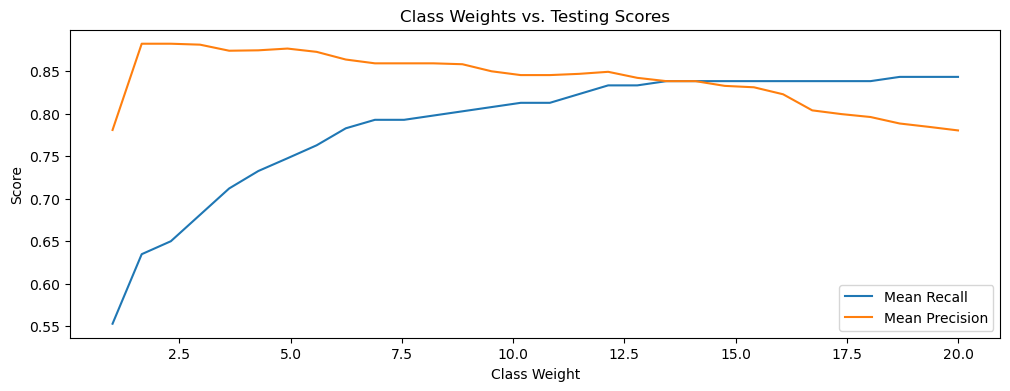

In [17]:
plt.figure(figsize=(12, 4))

for score in ['mean_test_recall_score', 'mean_test_precision']:
    plt.plot([_[1] for _ in cv_results_pr['param_class_weight']], cv_results_pr[score], label=score)

plt.title("Class Weights vs. Testing Scores")
plt.xlabel("Class Weight")
plt.ylabel("Score")

plt.legend(["Mean Recall", "Mean Precision"])

plt.show()

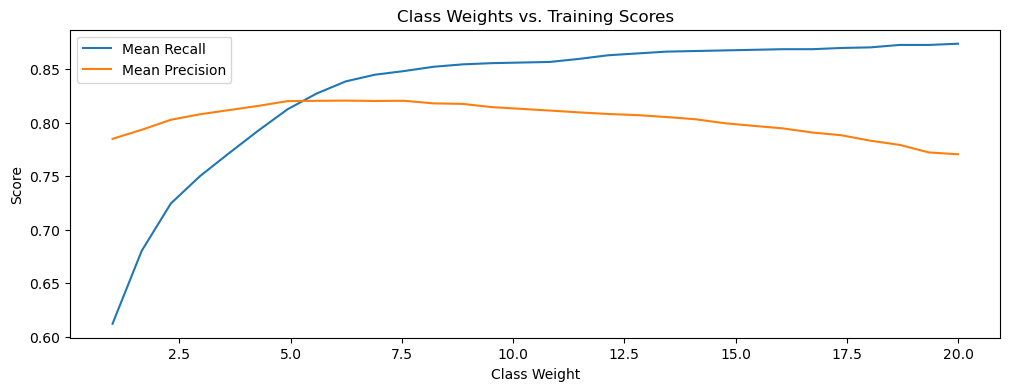

In [18]:
plt.figure(figsize=(12, 4))

for score in ['mean_train_recall_score', 'mean_train_precision']:
    plt.plot([_[1] for _ in cv_results_pr['param_class_weight']], cv_results_pr[score], label=score)

plt.title("Class Weights vs. Training Scores")
plt.xlabel("Class Weight")
plt.ylabel("Score")

plt.legend(["Mean Recall", "Mean Precision"])

plt.show()

In [19]:
def min_precision_recall1(y_true, y_pred):
    p_score = precision_score(y_true, y_pred)
    r_score = recall_score(y_true, y_pred)
    
    return min(p_score, r_score)

In [20]:
grid_pr2 = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={"precision": make_scorer(precision_score), 
             "recall_score": make_scorer(recall_score),
             "min_recall_precision": make_scorer(min_precision_recall1)},
    refit='min_recall_precision',
    return_train_score=True,
    cv=10,
    n_jobs=-1)

grid_pr2.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 16.724137931034484},
                                          {0: 1, 1: 17.379310344827587},
                                          {0: 1, 1: 18.03448275862069},
                                          {0: 1, 1: 18.689655172413794},
                                          {0: 1, 1: 19.344827586206897},
                                          {0: 1, 1: 20.0}]},
             refit='min_recall_precision', return_train_score=True,
             scoring={'min_recall_precision': make_scorer(min_precision_recall1),
                      'precision': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [21]:
cv_results_pr2 = pd.DataFrame(grid_pr2.cv_results_)

cv_results_pr2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,split2_train_min_recall_precision,split3_train_min_recall_precision,split4_train_min_recall_precision,split5_train_min_recall_precision,split6_train_min_recall_precision,split7_train_min_recall_precision,split8_train_min_recall_precision,split9_train_min_recall_precision,mean_train_min_recall_precision,std_train_min_recall_precision
0,1.160599,0.204849,0.024333,0.006984,"{0: 1, 1: 1.0}","{'class_weight': {0: 1, 1: 1.0}}",1.0,0.463415,0.583333,1.0,...,0.627119,0.548023,0.573864,0.573864,0.562500,0.613636,0.636364,0.607955,0.612185,0.054733
1,1.048195,0.085591,0.027727,0.012423,"{0: 1, 1: 1.6551724137931034}","{'class_weight': {0: 1, 1: 1.6551724137931034}}",1.0,0.463415,0.583333,1.0,...,0.683616,0.627119,0.670455,0.647727,0.630682,0.687500,0.698864,0.687500,0.680239,0.050286
2,1.048894,0.142309,0.024237,0.004062,"{0: 1, 1: 2.310344827586207}","{'class_weight': {0: 1, 1: 2.310344827586207}}",1.0,0.463415,0.583333,1.0,...,0.740113,0.683616,0.710227,0.698864,0.687500,0.715909,0.744318,0.727273,0.724454,0.043881
3,1.236002,0.103954,0.023929,0.004890,"{0: 1, 1: 2.9655172413793105}","{'class_weight': {0: 1, 1: 2.9655172413793105}}",1.0,0.452381,0.583333,1.0,...,0.785311,0.706215,0.744318,0.732955,0.715909,0.755682,0.772727,0.738636,0.749978,0.039589
4,0.916830,0.149158,0.026928,0.012919,"{0: 1, 1: 3.6206896551724137}","{'class_weight': {0: 1, 1: 3.6206896551724137}}",1.0,0.452381,0.583333,1.0,...,0.824859,0.740113,0.755682,0.744318,0.727273,0.778409,0.784091,0.761364,0.771498,0.037959


In [22]:
cv_results_pr2.sort_values(by='mean_test_min_recall_precision', ascending=False).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,split2_train_min_recall_precision,split3_train_min_recall_precision,split4_train_min_recall_precision,split5_train_min_recall_precision,split6_train_min_recall_precision,split7_train_min_recall_precision,split8_train_min_recall_precision,split9_train_min_recall_precision,mean_train_min_recall_precision,std_train_min_recall_precision
17,0.988069,0.117868,0.026531,0.007398,"{0: 1, 1: 12.137931034482758}","{'class_weight': {0: 1, 1: 12.137931034482758}}",0.857143,0.431818,0.576923,0.947368,...,0.828877,0.794737,0.801047,0.802139,0.787234,0.796875,0.794872,0.795812,0.807484,0.023328


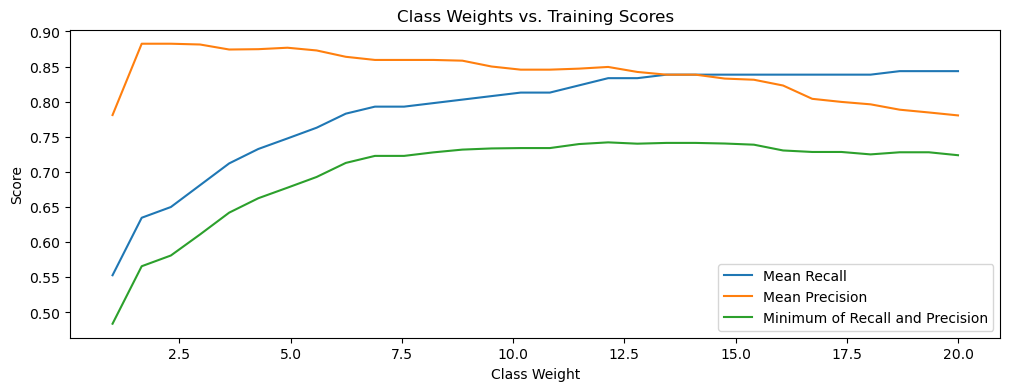

In [23]:
plt.figure(figsize=(12, 4))

for score in ['mean_test_recall_score', 'mean_test_precision', 'mean_test_min_recall_precision']:
    plt.plot([_[1] for _ in cv_results_pr2['param_class_weight']], cv_results_pr2[score], label=score)

plt.title("Class Weights vs. Training Scores")
plt.xlabel("Class Weight")
plt.ylabel("Score")

plt.legend(["Mean Recall", "Mean Precision", "Minimum of Recall and Precision"])

plt.show()

In [25]:
def min_precision_recall2(est, X, y_true, sample_weight=None):
    y_pred = est.predict(X)
    p_score = precision_score(y_true, y_pred)
    r_score = recall_score(y_true, y_pred)
    
    return min(p_score, r_score)

grid_pr2_2 = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={"precision": make_scorer(precision_score), 
             "recall_score": make_scorer(recall_score),
             "min_recall_precision": min_precision_recall2},
    refit='min_recall_precision',
    return_train_score=True,
    cv=10,
    n_jobs=-1)

grid_pr2_2.fit(X, y, sample_weight=np.log(1 + df['Amount']))

cv_results_pr2_2 = pd.DataFrame(grid_pr2_2.cv_results_)

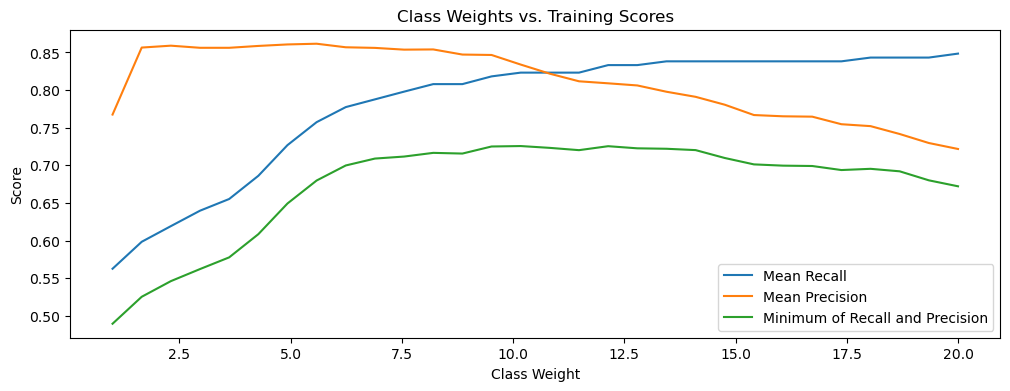

In [26]:
plt.figure(figsize=(12, 4))

for score in ['mean_test_recall_score', 'mean_test_precision', 'mean_test_min_recall_precision']:
    plt.plot([_[1] for _ in cv_results_pr2_2['param_class_weight']], cv_results_pr2_2[score], label=score)

plt.title("Class Weights vs. Training Scores")
plt.xlabel("Class Weight")
plt.ylabel("Score")

plt.legend(["Mean Recall", "Mean Precision", "Minimum of Recall and Precision"])

plt.show()

In [27]:
model2 = IsolationForest().fit(X)

print(f"Non-outliers\t: {Counter(np.where(model2.predict(X) == -1, 1, 0))[0]}\nOutliers\t: {Counter(np.where(model2.predict(X) == -1, 1, 0))[1]}")

Non-outliers	: 77227
Outliers	: 2773


In [28]:
def outlier_precision(mod, X, y):
    pred = mod.predict(X)
    return precision_score(y, np.where(pred==-1, 1, 0))

def outlier_recall(mod, X, y):
    pred = mod.predict(X)
    return recall_score(y, np.where(pred==-1, 1, 0))

grid_o = GridSearchCV(
    estimator=IsolationForest(),
    param_grid={
        'contamination': np.linspace(0.001, 0.02, 10)
    },
    scoring={
        'precision': outlier_precision,
        'recall': outlier_recall,
    },
    refit='precision',
    cv=5,
    n_jobs=-1
)

grid_o.fit(X, y)

GridSearchCV(cv=5, estimator=IsolationForest(), n_jobs=-1,
             param_grid={'contamination': array([0.001     , 0.00311111, 0.00522222, 0.00733333, 0.00944444,
       0.01155556, 0.01366667, 0.01577778, 0.01788889, 0.02      ])},
             refit='precision',
             scoring={'precision': <function outlier_precision at 0x000002A9082077E0>,
                      'recall': <function outlier_recall at 0x000002A908207BA0>})

In [29]:
cv_results_o = pd.DataFrame(grid_o.cv_results_)

cv_results_o.sort_values(by='mean_test_precision', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_contamination,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,1.402849,0.148981,0.572918,0.015093,0.001,{'contamination': 0.001},0.743590,0.666667,0.750000,0.000000,...,0.353985,1,0.397260,0.206897,0.266667,0.000000,0.000000,0.174165,0.154962,10
1,1.667342,0.089315,0.466552,0.040070,0.003111,{'contamination': 0.003111111111111111},0.500000,0.285714,0.528302,0.066667,...,0.174306,2,0.534247,0.482759,0.622222,0.105263,0.266667,0.402231,0.189144,9
2,1.361366,0.158628,0.388954,0.009997,0.005222,{'contamination': 0.005222222222222222},0.362205,0.104478,0.400000,0.066667,...,0.139757,3,0.630137,0.241379,0.711111,0.157895,0.366667,0.421438,0.215565,8
3,1.236354,0.026644,0.386073,0.015641,0.007333,{'contamination': 0.007333333333333333},0.313187,0.119048,0.276423,0.035714,...,0.105985,4,0.780822,0.517241,0.755556,0.157895,0.400000,0.522303,0.231955,7
4,1.233900,0.012270,0.367818,0.006834,0.009444,{'contamination': 0.009444444444444443},0.289720,0.132867,0.236842,0.031579,...,0.094999,5,0.849315,0.655172,0.800000,0.157895,0.466667,0.585810,0.251964,5


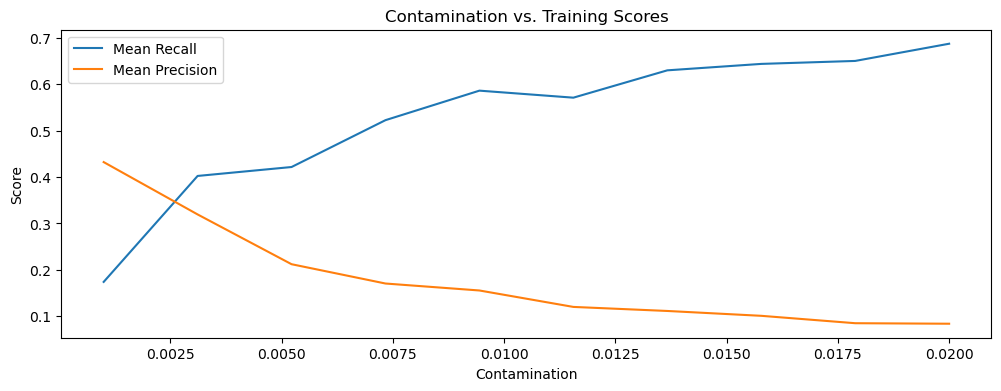

In [30]:
plt.figure(figsize=(12, 4))

for score in ['mean_test_recall', 'mean_test_precision']:
    plt.plot([_ for _ in cv_results_o['param_contamination']], cv_results_o[score], label=score)

plt.title("Contamination vs. Training Scores")
plt.xlabel("Contamination")
plt.ylabel("Score")

plt.legend(["Mean Recall", "Mean Precision"])

plt.show()